#### Simple Feed-Forward Neural Net
### Let's put everything together and build a NN to recognize MNIST dataset
That is, recognizing hand-written digits from 0 to 9

In [36]:
# MNIST
# DataLoader, Transformation
# Multilayer Neural Net, activation functions
# Loss and Optimizer
# Traning Loop (batch training)
# Model evaluation using accuracy (not the best but it works here for demo)
# GPU support, and CPU fallack

import torch
import torch.nn as nn
import torchvision # for datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper params
input_size = 784 # 28*28 images
hidden_size = 100 # num of nodes in one hidden layer
num_classes = 10 # 0~9
num_epochs = 5 # num of times we train through the entire dataset
batch_size = 100
learning_rate = 0.001

# MNIST
train_dataset = torchvision.datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Now let's see some data samples before building the net

In [37]:
examples = iter(train_loader)
samples, labels = examples.next()
samples.shape, labels.shape # (num of sample in batch, num channel of image, width/height, height, width), (num samples)

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

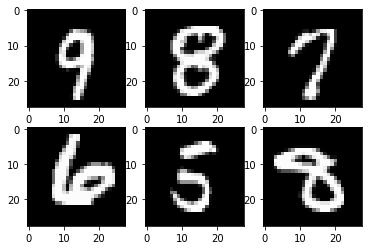

In [38]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')

### Build the neural net

In [39]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no softmax here because we are going to use cross entropy, and pytorch cross entropy function takes
        # care of softmax for us
        return out

In [40]:
# define model, like a function
model = NeuralNet(input_size, hidden_size, num_classes).to(device) # remember to keep result on same device

# loss and optimizer
criterion = nn.CrossEntropyLoss()  # this does softmax for us
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# training loop
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # shape is (100, 1, 28, 28) atm
        # but input to our nn first layer is 100, 784, so we need to reshape them
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward pass
        optimizer.zero_grad()   # remember to empty gradients from last time
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
            
# testing loop
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # again, we have to reshape images to fit the nn
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        # tracking
        _, predictions = torch.max(outputs, 1)  # max returns (value, index), and we care about the index
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
    acc = 100.0 * n_correct / n_samples
    print(f'acc: {acc}')

epoch 1 / 5, step 100/600, loss = 0.4456
epoch 1 / 5, step 200/600, loss = 0.2541
epoch 1 / 5, step 300/600, loss = 0.3288
epoch 1 / 5, step 400/600, loss = 0.3623
epoch 1 / 5, step 500/600, loss = 0.2666
epoch 1 / 5, step 600/600, loss = 0.2354
epoch 2 / 5, step 100/600, loss = 0.1693
epoch 2 / 5, step 200/600, loss = 0.0910
epoch 2 / 5, step 300/600, loss = 0.1668
epoch 2 / 5, step 400/600, loss = 0.1453
epoch 2 / 5, step 500/600, loss = 0.1112
epoch 2 / 5, step 600/600, loss = 0.1276
epoch 3 / 5, step 100/600, loss = 0.1419
epoch 3 / 5, step 200/600, loss = 0.0955
epoch 3 / 5, step 300/600, loss = 0.1763
epoch 3 / 5, step 400/600, loss = 0.1571
epoch 3 / 5, step 500/600, loss = 0.1248
epoch 3 / 5, step 600/600, loss = 0.2511
epoch 4 / 5, step 100/600, loss = 0.1200
epoch 4 / 5, step 200/600, loss = 0.0954
epoch 4 / 5, step 300/600, loss = 0.1471
epoch 4 / 5, step 400/600, loss = 0.0844
epoch 4 / 5, step 500/600, loss = 0.1051
epoch 4 / 5, step 600/600, loss = 0.0814
epoch 5 / 5, ste